In [3]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features, DataParser, MovingWindow
from tabulate import tabulate
from IPython.display import clear_output
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from utils import Position, Broker
from experts import PyConfig


cfg = cfg = PyConfig().test()
X, y = [], []
fsize=64
lab = "false"
def load(lab):
    dir = Path(f"data/231220-data/{lab}/")
    hist_pd, hist = DataParser(cfg).load()
    mw = MovingWindow(hist, fsize) 
    for fname in dir.glob("*.xlsx"):
        df = pd.read_excel(fname).iloc[0]
        f, _ = mw(df["Unnamed: 0"])
        x = build_features(f, 1, None, None, pd.to_datetime(df.Date), None)
        X.append([x])
        y.append({"true":[1, 0], "false":[0, 1]}[lab])

load("false")
load("true")
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
# rand_ids = np.random.shuffle(np.arange(y.shape[0]))
np.random.seed(0)
np.random.shuffle(X)
np.random.shuffle(y)
print(X.shape, y.shape)
print(f"{X[0, 0, -2, 0]:8.0f} -> {X[-1, 0, -2, 0]:8.0f}")

(74, 1, 5, 64) (74, 2)
     119 ->      166


In [5]:
X_train, X_test, y_train, y_test = X[:50], X[50:], y[:50], y[50:]

001 loss train: 2.7627 | test: 3.2788   ROC train: 0.4589 | test: 0.5035
002 loss train: 2.6471 | test: 3.2992   ROC train: 0.7037 | test: 0.4895
003 loss train: 2.5476 | test: 3.3030   ROC train: 0.7890 | test: 0.4895
004 loss train: 2.5018 | test: 3.2939   ROC train: 0.7971 | test: 0.4965
005 loss train: 2.4545 | test: 3.2761   ROC train: 0.7874 | test: 0.5175
006 loss train: 2.4176 | test: 3.2635   ROC train: 0.7987 | test: 0.4965
007 loss train: 2.3825 | test: 3.2588   ROC train: 0.8213 | test: 0.4895
008 loss train: 2.3536 | test: 3.2550   ROC train: 0.8293 | test: 0.4965
009 loss train: 2.3275 | test: 3.2495   ROC train: 0.8390 | test: 0.5105
010 loss train: 2.2985 | test: 3.2458   ROC train: 0.8357 | test: 0.4825
011 loss train: 2.2722 | test: 3.2471   ROC train: 0.8454 | test: 0.4755
012 loss train: 2.2475 | test: 3.2547   ROC train: 0.8519 | test: 0.4615
013 loss train: 2.2219 | test: 3.2685   ROC train: 0.8663 | test: 0.4476
014 loss train: 2.1968 | test: 3.2836   ROC train: 

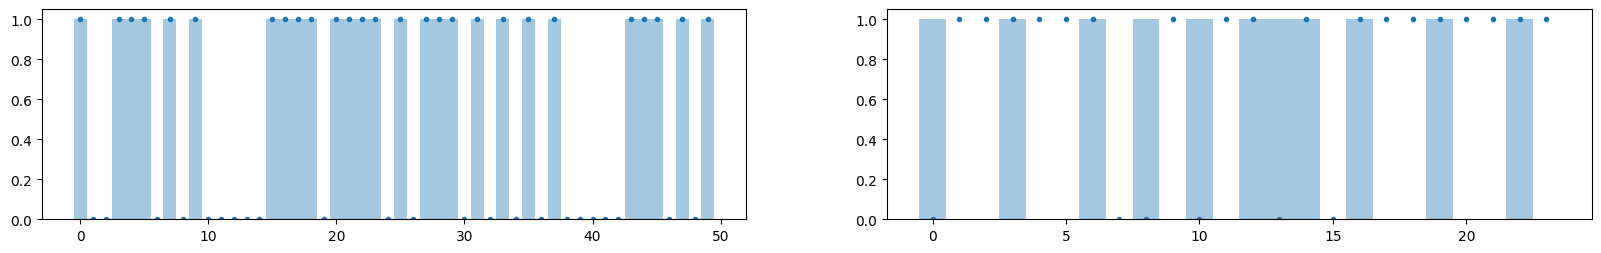

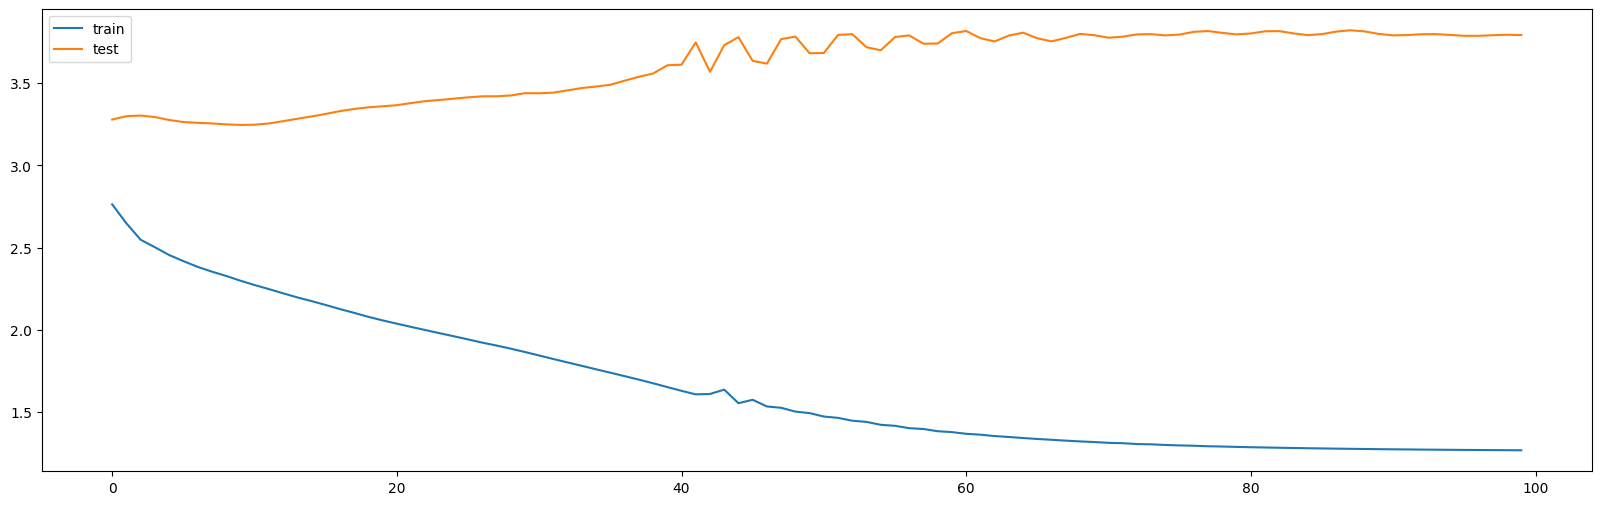

In [6]:
import torch
device = "mps"

nitrers = 10
test_split_size = 0.5
calc_test = True

pprofits, gprofits, metrics, table = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers)), []
for i in range(1):#int(1/test_split_size)):
    # X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test, _ = get_data(X, y, 3, test_split_size, 0, 1)
    X_train = torch.tensor(X_train).float().to(device)
    X_test = torch.tensor(X_test).float().to(device)
    model, loss_hist = train(X_train, y_train, X_test, y_test, batch_size=50, epochs=100, device=device, calc_test=calc_test)
    model.eval()
    p_test = model.predict(X_test)
    p_train = model.predict(X_train)
        
plt.figure(figsize=(20, 6))
plt.subplot(2, 2, 1)
plt.plot(p_train, ".")
plt.bar(np.arange(p_train.shape[0]), y_train.argmax(1), width=[1]*p_train.shape[0], alpha=0.4)
# plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    plt.subplot(2, 2, 2)
    plt.plot(p_test, ".")
    plt.bar(np.arange(p_test.shape[0]), y_test.argmax(1), width=[1]*p_test.shape[0], alpha=0.4)
plt.figure(figsize=(20, 6))
plt.plot(loss_hist)
plt.legend(["train", "test"])
# torch.save(model.state_dict(), "model.pth")

In [ ]:
(np.eye(5)[p_train]*y_train).sum(), y_train.sum(0)

In [ ]:
import sys
from experts import ExpertFormation, PyConfig
from backtest import backtest
from pathlib import Path
from dataloading import get_data, collect_train_data
import numpy as np
from loguru import logger
from tqdm import tqdm
import torch
from ml import train
import matplotlib.pyplot as plt
logger.remove()
logger.add(sys.stderr, level="INFO")



test_split_size = 0.2
device = "mps"
cfg = PyConfig().test()
cfg.run_model_device = device

for _ in range(5):
    legend, last_prof = [], 0
    for i in range(int(1/test_split_size)):
        X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test, test_dates = get_data(X, y, 1, test_split_size, i, i+1)
        X_train = torch.tensor(X_train).float().to(device)
        model, hist = train(X_train, y_train, None, None, batch_size=1024, epochs=10, device=device, calc_test=False)
        model.eval()
        # X_train = X_train.float().to(device)
        # p_train = model(X_train).detach().cpu().numpy().squeeze()[:, 0]    
        # profsum_best, threshold = -999999, np.percentile(p_train, 10)
        # for th in np.arange(0., 0.9, 0.025):
        #     profsum = f1_score(y_train[:, 0], p_train>th)
        #     if profsum > profsum_best:
        #         profsum_best = profsum
        #         threshold = th
        # model.set_threshold(threshold)
        torch.save(model.state_dict(), "model.pth")
        cfg.date_start=f"{test_dates[0][:4]}-{test_dates[0][4:6]}-{test_dates[0][6:]}"
        cfg.date_end=f"{test_dates[1][:4]}-{test_dates[1][4:6]}-{test_dates[1][6:]}"
        brok_results = backtest(cfg)
        cumsum = brok_results.profits.cumsum()
        print(brok_results.profits.sum())
        plt.plot([pos.close_date for pos in brok_results.positions], cumsum + last_prof)
        last_prof += cumsum[-1]
        plt.grid("on")
        plt.tight_layout()
        legend.append(f"{test_dates[0]}-{test_dates[1]}")

cfg.run_model_device = None
cfg.date_start="2004-01-01"
cfg.date_end="2024-01-01"
brok_results = backtest(cfg)
print(brok_results.profits.sum())
plt.plot([pos.close_date for pos in brok_results.positions], brok_results.profits.cumsum(), linewidth=3, alpha=0.6)
legend.append("baseline")
# plt.legend(legend)
plt.savefig("backtest.png")
# plt.show()

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 64)
model.load_state_dict(torch.load("model.pth"))
model.eval()
model.to(device)

In [ ]:
p = model.forward_thresholded(X_test)[:, 0]
w_profs_test = calc_weights(p_test[0], threshold)
pprofs_test = (profs_test*w_profs_test).sum(0)
pprofs_test, profs_test.sum()

In [ ]:
pprofs_sum1 = np.nansum(pprofits, 1)
gprofs_sum1 = np.nansum(gprofits, 1)
pprofs_sum1, gprofs_sum1, (pprofs_sum1-gprofs_sum1)/abs(gprofs_sum1)

In [ ]:
plt.plot(np.array(table)[:, 3], ".-")

In [ ]:
p_train.mean(), threshold

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 32)
model.load_state_dict(torch.load("model.pth"))
model.eval()
# model.set_threshold(-6)
model.to(device)
X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split=1)
p_test = model(torch.tensor(X_test).float().to(device)).squeeze()
# profs_test.sum(), (profs_test*p_test).sum()
p_test

In [ ]:
X_train.shape

In [ ]:
list(model.named_parameters())[0]

In [ ]:
plt.plot(model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy())

In [ ]:
threshold

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

In [ ]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [ ]:
prediction